# Pump it Up: Data Mining the Water Table

## Methodology 

In this notebook, we will only show the features selection, dimensionality reduction and modelling that gave us the high score; However, we will comment on all the trails we made prior to come to our final best score.

### Data understanding
Understand the data distribution, the amount of levels per features, the target distribution, etc..
### Features engineering
- 1) Dealing with missing values: replacing missing values (with modes or “None”)
- 2) Features selection: discard not informative enough features (mostly because they contain to mainly levels)
- 3) Dimensionality reduction: reduce the amount of level per features 
- 4) Label Encoder: Choose Label Encoder over One Hot Encoder (the features have still a lot of dimensions)

### Modelling
- 1) Base model: Random Forest
- 2) Element Ensemble: Voting Classifier

### Prediction
Out of Sample predication

### Conclusion
Interpretation of the most important features and potential further improvement of our analysis and modelling



**Best out of sample score 82.55 % - Top 1% as of March 2018**

[Competition link](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/)


### Authors: Cedric Viret and Alexandre Olivier 

#### Importing basic libraries

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
from scipy.stats import norm, skew
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Impot data

In [95]:
training = pd.read_csv("Training.csv")
test =  pd.read_csv("Test.csv")
Y_training = pd.read_csv("Y_Training.csv")


#### Basic maniplulation on the data

In [96]:
#shape of the csv
print("Making sure that download data are accurate")
print("training shape:",training.shape)
print("test shape:",test.shape)
print("training target shape:",Y_training.shape)
print("--------------------------------------")

#merge Y_training and training
training = training.merge(Y_training, left_on='id', right_on='id', how='inner')
print("Merge training + target:",training.shape)
print("--------------------------------------")

#check is ID is unique
print("check if ID are unique:", len(training.id.unique()) == len(training))
print("check if ID are unique:", len(test.id.unique()) == len(test))
print("--------------------------------------")

#Id's are unique we store them and remove them
training_id = training.id
test_id = test.id
training = training.drop("id", inplace = False, axis = 1)
test = test.drop("id", inplace = False, axis = 1)


#print(final shape)
print("Final Training shape:",training.shape)
print("Final Testing shape:",test.shape)

#concante test and training
print("")
print("---------concat data-----------")
y = pd.DataFrame({'status_group':training.status_group})
print("y shape:",y.shape)
features = training.drop('status_group', inplace = False, axis = 1)
features = pd.concat([features, test]).reset_index(drop=True)
print("features shape:",features.shape)


Making sure that download data are accurate
training shape: (59400, 40)
test shape: (14850, 40)
training target shape: (59400, 2)
--------------------------------------
Merge training + target: (59400, 41)
--------------------------------------
check if ID are unique: True
check if ID are unique: True
--------------------------------------
Final Training shape: (59400, 40)
Final Testing shape: (14850, 39)

---------concat data-----------
y shape: (59400, 1)
features shape: (74250, 39)


After this manipulation, we have:<br>
-  "features" that contains all the features form the original dataset
-  "y" which is the target variable with 3 levels: "functional", "functional needs repair" and "non functional"<br>

**It is a multiclass classification problem**

### Data understanding

In [97]:
pd.set_option('max_columns', None)
features.head(2)


,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [98]:
#data type
print(features.dtypes)

amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_type              object
water_qual

Having a look at the 39 features of the dataset we realized that we have only 9 numerical features; while the others are categorical with a **crazy amount of level per feature** - therefore we will have to somehow find a way to reduce the dimensiality of our features to have a good modelling result.

#### Understanding target distribution

In [99]:
y_grouped = y.groupby('status_group')['status_group'].count()
y_grouped_index = y_grouped.index
y_grouped_prct = y_grouped / len(y)
pd.DataFrame(list(zip(y_grouped_index,y_grouped, y_grouped_prct )), columns=['Class', 'y_value', 'y_value_prct'])

,Class,y_value,y_value_prct
0,functional,32259,0.543081
1,functional needs repair,4317,0.072677
2,non functional,22824,0.384242


Looking at the distribution of the target variable we see that the class "functional needs repair" is low compare to the other two ('<10%') - potential imbalance distribution.<br>
So we already know that for our cross validation strategry we will choose "StratifiedKFold" over a "NormalKfold" - it fits better for imbalance classes.

### Features engineering

It is compose of three main parts:
- 1) Dealing with with missing values
- 2) Features selection
- 3) Dimensionality reduction <br>

For each sections with will list all the trails we made but only show the code that give us the best model.

#### Dealing with missing values

In [100]:
#understand the missing vales
nulls = np.sum(features.isnull())
nullcols = nulls.loc[(nulls != 0)]
dtypes = features.dtypes
dtypes2 = dtypes.loc[(nulls != 0)]
nullcols2 = nullcols / len(features)
info = pd.concat([nullcols,nullcols2, dtypes2], axis=1).sort_values(by=0, ascending=False)
print(info)
print("There are", len(nullcols), "columns with missing values")

                       0         1       2
scheme_name        35258  0.474855  object
scheme_management   4846  0.065266  object
installer           4532  0.061037  object
funder              4504  0.060660  object
public_meeting      4155  0.055960  object
permit              3793  0.051084  object
subvillage           470  0.006330  object
There are 7 columns with missing values


Except for scheme_name, all the featires have less that 10% missing values.<br>
We tried to better understand the missing values patterns with a graph.

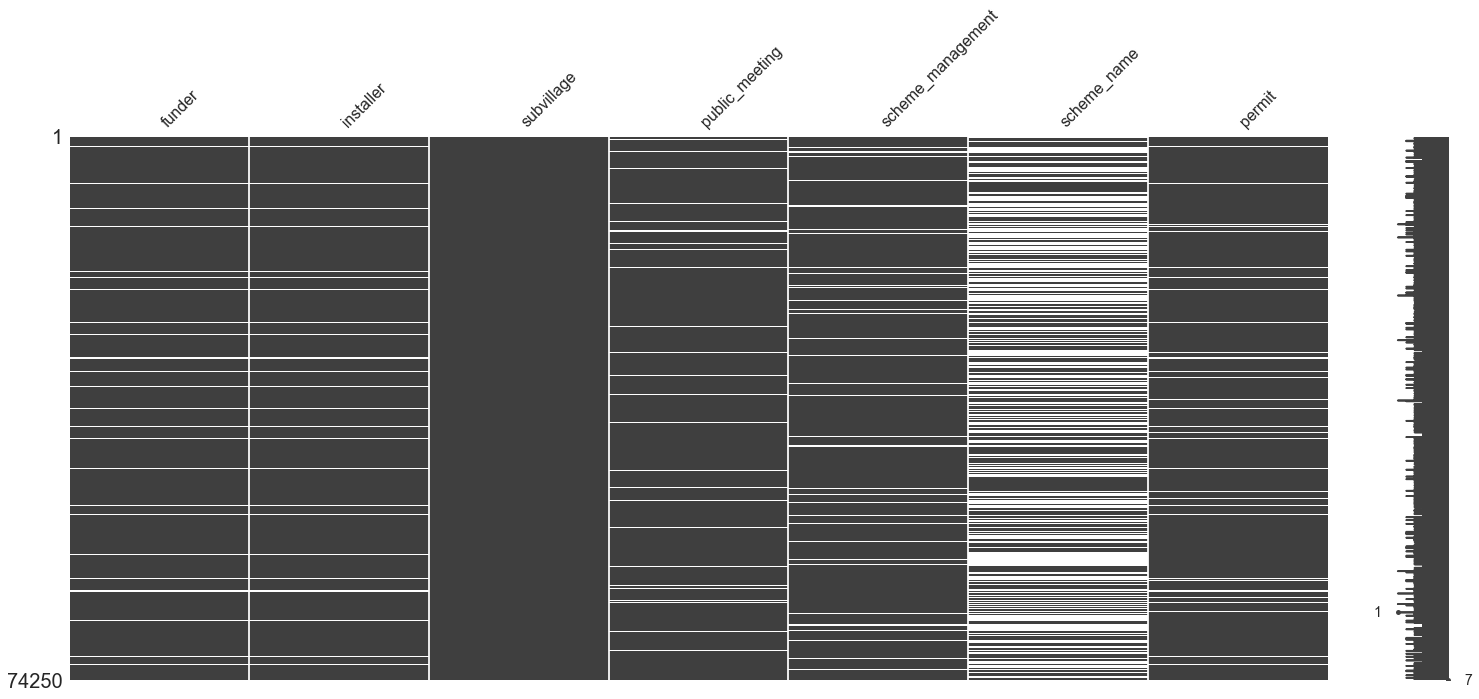

In [101]:
import missingno as msno
missingdata_df = features.columns[features.isnull().any()].tolist()
msno.matrix(features[missingdata_df])

With this matrix it seems that funder and installer have the same missing values; for the other features there is no clear pattern.

In [102]:
#copy of the features before Nan imputation
feature_initial = pd.DataFrame.copy(features)

#### Na imputation<br>

To deal with NaN values we try different approaches:
- 1) using KNN from package FancyImpute to fill the Nan. We were not able to implement it properly. Because fancy impute only work with numerical features... We tried to convert all the categorical features into numerical before applying Fancy impute but even with those it was not working properly (for instance: KNN return 1.2 for a categorical variable that could either be 1 or 2). With this kind of results we could not have any meaningful output. so we tried:
- 2) unsupervised KNN. To do that we used all the rows with missing values as testing set and the rows without Nan as training. It worked, however the results on our base model were not satisfying so we use decided on a last approach:
- 3) standard approach where we filled this NaN by either "None" or features ‘mode.


**“Scheme_name”, installer, funder and “subvillage” we replaced the missing values by "None".** <br>

- 1) “Scheme_name” have so many NaN that we create a category called "None" for all the missing information
- 2) installer, funder and “subvillage”, we could not find any relevant information related to those missing values and the other features so we apply the category "None".


In [103]:
features.scheme_name.fillna('None', inplace = True) # to many level inside the class to do anything
features.installer.fillna('None', inplace = True) #none again to many catergory
features.funder.fillna('None', inplace = True) #none again to many catergoy
features.subvillage.fillna('None', inplace = True) #none again to many catergoy


**For "scheme_management", "public_meeting" and "permit" we imputed the mode of each features.**<br>


- 1) There are not a lot of levels for those features - so we choose to not increase it with another category such as "None" - especially knowing that what we already have, overall, some many levels for each features (it would add more complexity).
- 2) After many changes we realized that our baseline model produces a better in and out of sample accuracy score with mode instead of assigning another class to the missing NaNs.

In [104]:
features.scheme_management.fillna(features['scheme_management'].mode()[0], inplace = True) #on the class mode
features.public_meeting.fillna(features['public_meeting'].mode()[0], inplace = True) #on the class mode
features.permit.fillna(features['permit'].mode()[0], inplace = True) #on the class mode


In [105]:
#CHECKING for Nans
nulls = np.sum(features.isnull())
nullcols = nulls.loc[(nulls != 0)]
dtypes = features.dtypes
dtypes2 = dtypes.loc[(nulls != 0)]
nullcols2 = nullcols / len(features)
info = pd.concat([nullcols,nullcols2, dtypes2], axis=1).sort_values(by=0, ascending=False)
print("There are", len(nullcols), "columns with missing values")

There are 0 columns with missing values


#### Features Selection - Dimensionality Reduction
In this section we apply the same logic to each categorical features:
- 1) we apply the created function: *serie_understanding* to have a data frame with the amount and percentage of each unique levels for each features
- 2) if needed, we transform the features by grouping the lower level together - (*function replacement*)


In [106]:
#function to understand the serie:
def serie_understanding(serie):
    group = features.groupby(serie)[serie].count()
    df = pd.DataFrame(list(zip(group.index, group, group/sum(group))), columns = ['Class', 'Count', 'Percentage']).sort_values('Percentage', ascending = False)
    return df

#########
def replacement(thresold, colum):
    list1 = []
    thresold = int(thresold)
    for a,b in zip(df.Count, df.Class): 
        if a <= thresold:
            list1.append(b)
    ###
    for i in list1:
        features[colum].replace([i],"Group", inplace = True)
    print("REPACEMENT DONE WITH A THRESHOLD OF", thresold)

##### Understanding class distribution per catergorical features

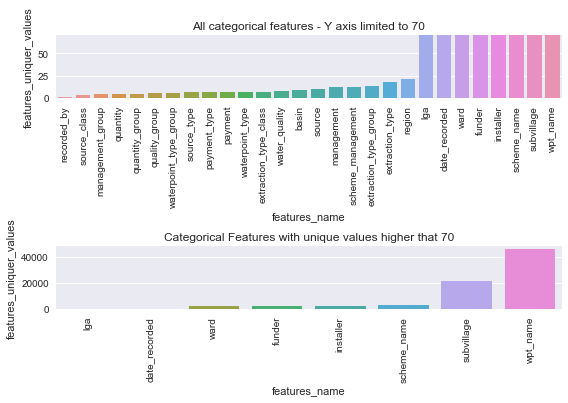

In [107]:
from itertools import chain
objects = []
features_name = []

#Getting number of levels for each features
for i in features.columns:
    if features[i].dtype == object:
        objects.append(len(features[i].unique()))
        features_name.append([i])
        #print([i],len(features[i].unique()), features[i].dtype) to have all the features not only the object type


#creating a list instead of a list of a list for feature_name
features_name = list(chain.from_iterable(features_name))

#create a dataframes
graph_df = pd.DataFrame()
graph_df['features_name'] = features_name
graph_df['features_uniquer_values'] = objects

#first DF
graph_df.sort_values('features_uniquer_values', axis=0, ascending=True, inplace=True, kind='quicksort', na_position='last')
#second df
graph_df2 = graph_df[graph_df['features_uniquer_values'] >= 70].sort_values('features_uniquer_values', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

print("")

"-------------------------graphs-------------------------"
#plot1
plt.subplot(2,1,1)
plt.legend("All categorical features - Y axis limited to 70")

plt.xticks(rotation=90)
plt.ylim(ymax=70)
sns.barplot(x=graph_df['features_name'], y="features_uniquer_values", data = graph_df)
plt.title('All categorical features - Y axis limited to 70')

#plot2
plt.subplot(2,1,2)
plt.xticks(rotation=90)
sns.barplot(x='features_name', y="features_uniquer_values", data = graph_df2)
plt.title('Categorical Features with unique values higher that 70')

plt.tight_layout()


With these plots we can clearly see that we have 8 features with more than 70 classes, with two of them having more than 2000 classes. To handle that problem we look at each feature individually to see if we could find patterns in each class of the features. Below an example on how we proceeded.

In [108]:
df = serie_understanding('extraction_type') #Calling the function to run a the serie
df #printing dataframe that is composed of Class Count amount of unique value and pourcentage (that for only one serie in the DF)

,Class,Count,Percentage
3,gravity,33263,0.447987
8,nira/tanira,10205,0.137441
9,other,8102,0.109118
14,submersible,5982,0.080566
15,swn 80,4588,0.061791
7,mono,3628,0.048862
4,india mark ii,3029,0.040795
0,afridev,2208,0.029737
6,ksb,1790,0.024108
12,other - rope pump,572,0.007704


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]), <a list of 18 Text xticklabel objects>)

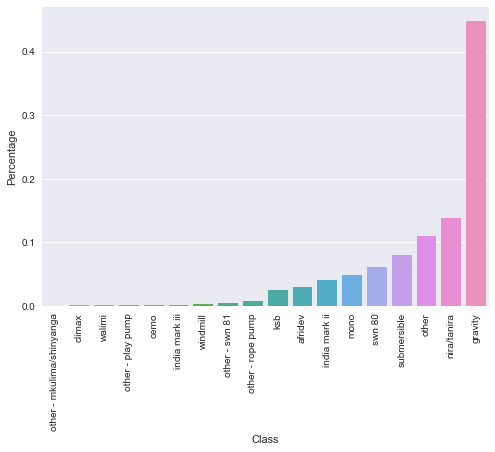

In [109]:
#visual representation of the serie
df.sort_values('Percentage', axis=0, ascending=True, inplace=True, kind='quicksort', na_position='last')
sns.barplot(df.Class, df.Percentage)
plt.xticks(rotation=90)

We used both the data frame (with Class, unique value amount and percentage) and the graph to perform features selections and dimensionality reduction. We will only comment on the features change for the rest on the notebook and not show the graph and data frame anymore to avoid making it too long.

we dropped 3 features because:
- 1) “subvillage” has to many class so we wanted to avoid adding noise to the data
- 2) “recorded_by” has only 1 class, so it can be dropped
- 3) “num_private” do not add any valuable information to the analysis


In [110]:
features.drop("subvillage", inplace = True, axis = 1) # not relevant
features.drop("num_private", inplace = True, axis = 1) # not relevant
features.drop("recorded_by", inplace = True, axis = 1) #only one values so it can be deleted

#### Dimensionality reduction <br>
We tried using PCA and LDA to reduce dimension of our data, however the impact of either PCA or LDA was not significant on our base model, therefore we use a more "manual" approach, where we group the features by threshold. <br>

**We know that by doing that we do not take into consideration any interaction between features when applying some dimensionality reduction, since we reduce each feature one by one. However, that method gave us our best accuracy score. **


Group into one class all the unique values for “funder”, “installer”, “wpt_name”, “scheme_name”.

In [111]:
df = serie_understanding('funder')
replacement(1, 'funder')

REPACEMENT DONE WITH A THRESHOLD OF 1


In [112]:
df = serie_understanding('installer')
replacement(1, 'installer')

REPACEMENT DONE WITH A THRESHOLD OF 1


In [113]:
df = serie_understanding('wpt_name')
replacement(1, 'wpt_name')

REPACEMENT DONE WITH A THRESHOLD OF 1


In [114]:
df = serie_understanding('scheme_name') # keep ward as it is
replacement(1, 'scheme_name')

REPACEMENT DONE WITH A THRESHOLD OF 1


#### Changing features types<br>
“Region_code” and “district_code” should be categorical rather that numerical


In [115]:
features['region_code'] = features['region_code'].astype(str) #changing type for region_code
features['district_code'] = features['district_code'].astype(str) #changing type for district_code


**For the remaining features we did not perform any features selection or dimensionality reduction**

#### Reducing scale from numerical variable<br>
We applied MinMaxscaler to reduce the scale of the numerical features

In [116]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

features_ti = ['amount_tsh', 'gps_height', 'longitude', 'latitude', 'population','construction_year' ]
for i in features_ti:
    min_max_scaler.fit_transform(features[i].reshape(-1,1))


#### Label Encoder<br>
We used Label Encoder over One Hot Encoder for dummy creation because we still have our features containing a lot of dimensions (levels).

In [117]:
from sklearn.preprocessing import LabelEncoder
features_to = ['date_recorded', 'funder', 'installer', 'wpt_name', 'basin', 'region','region_code', 'district_code','lga',
              'ward', 'public_meeting', 'scheme_management', 'scheme_name', 'permit', 'extraction_type',
              'extraction_type_group', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment',
              'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source','source_type', 'source_class',
              'waterpoint_type', 'waterpoint_type_group']

# process columns, apply LabelEncoder to categorical features
cols = features_to
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(features[c].values)) 
    features[c] = lbl.transform(list(features[c].values))

# shape        
print('Shape all_data: {}'.format(features.shape))


Shape all_data: (74250, 36)


#### Spliting Features into Training (X) and Testing

In [118]:
X = features.iloc[:len(training),:]
testing_features = features.iloc[len(training):,:]

### Modelling

#### Importing Modelling Librarbies

In [119]:
#model selection:
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV,RandomizedSearchCV

#models
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

#discriminant
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#Evaluation
from sklearn.metrics import accuracy_score

#Hide Warning
#import warnings
#warnings.filterwarnings('ignore')

#### Cross validation strategy.<br>
As mentionned earlier in the note book we will used StratifiedKFold over KFold.

In [120]:
#cross validation
kfold = StratifiedKFold(n_splits=7, random_state=42, shuffle=True)

#### Base Model <br>
Since it is a classification problem we choose as a base model: RandomForestClassifier

In [137]:

rf = RandomForestClassifier()
clf = rf.fit(X, y) 

In [138]:
cross_val =  cross_val_score(clf, X, y, scoring='accuracy', cv = kfold)
print("Base line model: Random Forest average score:",cross_val.mean()*100)

Base line model: Random Forest average score: 80.03874502833774


After having a descent base model score, we tried different models with different parameters. To find the optimal parameters we used Gridsearch.<br>
**we will not show all the models trials**, however our best single model **Out of Sample results** was 80% using Random Forest Classifier with best parameters.


#### All the Models (with best paramters) <br>
we did not used SVM because of the number of levels per feature - even the simple SVM was taking too long to converge. We also tried with CatBoost, but it seems that CatBoost is facing some implementation issue in python, so we were not able to use it.

In [30]:
#RANDOM FOREST
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=42, verbose=0,
            warm_start=False)

#XBBOOST
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.4, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

#ADABOOST
ada = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.8, n_estimators=1000, random_state=None)

#LIGHTGBM
gbm = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.3, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=300,
        n_jobs=-1, num_leaves=40, objective='binary', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)

#Gradient Boosting Classifier
gbc = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.6, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)


#### Element Ensemble <br>
Improving our best single results we used soft Voting Classifier to create an element Ensemble.

In [31]:
VC = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb), ('ada', ada), ('gnm', gbm), ('gbc', gbc)], voting='soft')

for clf, label in zip([rf, xgb, ada, gbm,gbc, VC], ['Random Forest','XGBoost','Ada Boost', 'Light GBM', 'Gradient Boosting', 'Ensemble']):
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was pa

Accuracy: 0.82 (+/- 0.00) [Random Forest]


C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to 

Accuracy: 0.80 (+/- 0.00) [XGBoost]


C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

Accuracy: 0.75 (+/- 0.00) [Ada Boost]


C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to 

Accuracy: 0.81 (+/- 0.00) [Light GBM]


C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

Accuracy: 0.80 (+/- 0.00) [Gradient Boosting]


C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to 

Accuracy: 0.81 (+/- 0.00) [Ensemble]


C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


We realized that some of our model where lowering down the score of our Ensemble model, therefore we only use the Random Forest with Light GBM for our final prediction - which gave us our best score.

#### Best element ensemble

In [130]:
VC = VotingClassifier(estimators=[('rf', rf),('gnm', gbm)], voting='soft')

### Prediction

In [131]:
prediction = VC.fit(X,y).predict(testing_features)

In [133]:
submission = pd.DataFrame()
submission['id'] = test_id
submission['status_group'] = prediction

submission.to_csv("Final_score2",index = False)

### Conclusion
#### Interpretation <br>
To try to improve our best single results we used soft Voting Classifier to create an element Ensemble. We use a *soft* voting method which predicts the class label based on the argmax of the sums of the predicted probability. <br>
As such, it is actually not simple to interpret our final model. The only thing we found to interpret is to look at the feature importance for both random forest and lightgbm. <br>
Below, we printed to top 10 most "important" features for both models separately. We notice that they share 8 out of the top 10 in both cases. We can say that the following are the most important features of our model: Longitute, lattitute, gps_height, date_recorded, wpt_name, construction, ward and population. <br>
Note: The feature_importances_ is an estimate to what fraction of the input samples' classification a feature contributes to.<br>
1.0 would mean you have a feature that alone classifies all samples, 0.0 would indicate a feature that can add no (additional) value for classification in the case of random forest.


#### Further improvement 

we could have used external data sources to impute some missing values based on the geolocation coordinate – we could also have used Autoencoder Neural Network to reduce the dimensions of the data set, it might have performed better that PCA because it would have capture non-linear dependencies between the features (PCA only captures linear dependencies). 

In [124]:
df = pd.DataFrame(list(zip(X.columns.values, rf.fit(X,y).feature_importances_ )), columns = ['Feature', 'Importance']).sort_values('Importance', ascending = False)
df.head(10)

,Feature,Importance
5,longitude,0.104954
6,latitude,0.098413
30,quantity_group,0.071755
29,quantity,0.058926
3,gps_height,0.050851
1,date_recorded,0.048012
7,wpt_name,0.040965
19,construction_year,0.038178
13,ward,0.036610
14,population,0.035528


In [129]:
df = pd.DataFrame(list(zip(X.columns.values, gbm.fit(X,y).feature_importances_ )), columns = ['Feature', 'Importance']).sort_values('Importance', ascending = False)
df.head(10)

,Feature,Importance
3,gps_height,2884
6,latitude,2807
1,date_recorded,2789
13,ward,2748
7,wpt_name,2667
14,population,2633
5,longitude,2495
2,funder,1834
19,construction_year,1680
17,scheme_name,1536


### Conclusion

### AD Hoc Finding best Parameters for algroithms - gridsearch

Warning: all the code below takes a really long time to run<br>
RF

In [414]:
grid = {
   'n_estimators': [100, 200, 500, 800, 1000],
    'max_features': ['log2', 'auto', 'sqrt'],
    'max_depth' : [None,6,8, 10],
    "min_samples_split" : [2, 5, 20,50],
    'random_state':[42]
}

"Sklearn"
"-----------------------"
rf_grid_search = GridSearchCV(rf, param_grid = grid, cv = kfold, verbose = 10, n_jobs = 2, pre_dispatch = '2*n_jobs')
rf_grid_search.fit(X, y)
print("best parameters: ", rf_grid_search.best_params_)
best_rf_grid_search = rf_grid_search.best_estimator_
best_rf_grid_search.fit(X,y)
cross_val =  cross_val_score(best_rf_grid_search.fit(X,y), X, y, scoring='accuracy', cv = kfold)
print(cross_val.mean())


Fitting 7 folds for each of 240 candidates, totalling 1680 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   17.0s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   36.3s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  2.9min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  7.6min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed: 14.3min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed: 22.4min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 24.3min
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed: 30.7min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed: 42.7min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed: 46.1min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed: 53.8min
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed: 66.2min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed: 70.9min
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed: 84.5min
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed: 90.5min
[Parallel(n_jobs=2)]: Do

best parameters:  {'max_depth': None, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 500, 'random_state': 42}
0.817929743169


In [418]:
best_rf_grid_search

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [412]:
xgb = XGBClassifier()
grid = {
    'n_estimators': [450, 600, 800, 1000],
    'learning_rate': [.2, .4, .6, .8],
    'objective':['multi:softmax', 'binary:logistic'],
    #'min_child_weight':[1,3],
    #'max_depth':[5,6,8],
    
    
}

xgb_grid_search = GridSearchCV(xgb, param_grid = grid, cv = kfold, verbose = 10, n_jobs = 2, pre_dispatch = '2*n_jobs')
xgb_grid_search.fit(X, y)


print("best parameters: ", xgb_grid_search.best_params_)
best_xgb_grid_search = xgb_grid_search.best_estimator_
best_xgb_grid_search.fit(X,y)
cross_val =  cross_val_score(best_xgb_grid_search, X, y, scoring='accuracy', cv = kfold)
print(cross_val.mean())


Fitting 7 folds for each of 32 candidates, totalling 224 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  2.7min
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  6.7min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  9.5min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed: 16.4min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed: 21.9min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed: 33.3min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 44.2min
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed: 60.2min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed: 67.1min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed: 78.5min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed: 92.6min
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed: 114.1min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed: 125.8min
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed: 140.6min
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed: 161.4min
[Parallel(n_jobs=2)]

best parameters:  {'learning_rate': 0.4, 'n_estimators': 1000, 'objective': 'multi:softmax'}
0.804023522929


In [419]:
best_xgb_grid_search

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.4, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [413]:
lgm = LGBMClassifier()
grid = {'boosting_type':['gbdt'],
        'n_estimators':[100,300,800],
        'learning_rate':[0.3,0.6,0.8],
        #'min_data_in_leaf':[15,20,35],
        #'cat_smooth':[10,20,30],
        'num_leaves':[31,40,50],
        'objective':['binary', 'multiclass']}

lightgbm_grid_search = GridSearchCV(lgm, param_grid = grid, cv = kfold, verbose = 10, n_jobs = 2, pre_dispatch = '2*n_jobs')             
lightgbm_grid_search.fit(X,y)

print("best parameters: ", lightgbm_grid_search.best_params_)
best_lightgbm_grid_search= lightgbm_grid_search.best_estimator_
best_lightgbm_grid_search.fit(X,y)
cross_val =  cross_val_score(best_lightgbm_grid_search, X, y, scoring='accuracy', cv = kfold)
print(cross_val.mean())

Fitting 7 folds for each of 54 candidates, totalling 378 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    6.5s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   14.8s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   28.2s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   41.6s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  1.0min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  2.5min
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:  3.9min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  5.3min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:  7.2min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed: 10.5min
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed: 15.6min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed: 20.5min
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed: 22.0min
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed: 22.8min
[Parallel(n_jobs=2)]: Do

best parameters:  {'boosting_type': 'gbdt', 'learning_rate': 0.3, 'n_estimators': 300, 'num_leaves': 40, 'objective': 'binary'}
0.810236014433


In [415]:
ada = AdaBoostClassifier()
grid = {
    'n_estimators': [450, 600, 800, 1000],
    'learning_rate': [.1, .4, .6, .8],
    'random_state':[42]
}

ada_grid_search = GridSearchCV(ada, param_grid = grid, cv = kfold, verbose = 10, n_jobs = 2, pre_dispatch = '2*n_jobs')
ada_grid_search.fit(X, y)
print("best parameters: ", ada_grid_search.best_params_)


Fitting 7 folds for each of 16 candidates, totalling 112 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  3.0min
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  7.3min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed: 11.3min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed: 20.0min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed: 30.2min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed: 36.0min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 45.6min
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed: 59.5min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed: 67.8min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed: 84.0min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed: 95.5min
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed: 112.3min
[Parallel(n_jobs=2)]: Done 112 out of 112 | elapsed: 116.7min finished


best parameters:  {'learning_rate': 0.8, 'n_estimators': 1000, 'random_state': 42}


In [416]:
gbc = GradientBoostingClassifier()
grid = {
        'n_estimators':[100,300,800, 1000],
        'learning_rate':[0.6,0.8, 1],
         'max_depth': [3,6]}
gbc_grid_search = GridSearchCV(gbc, param_grid = grid, cv = kfold, verbose = 10, n_jobs = 2, pre_dispatch = '2*n_jobs')
gbc_grid_search.fit(X, y)
print("best parameters: ", gbc_grid_search.best_params_)
best_gbc_grid_search= gbc_grid_search.best_estimator_
#best_lightgbm_grid_search.fit(X,y)
#cross_val =  cross_val_score(best_lightgbm_grid_search, X, y, scoring='accuracy', cv = kfold)
#print(cross_val.mean())


Fitting 7 folds for each of 24 candidates, totalling 168 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   47.8s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  5.1min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed: 10.8min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed: 31.2min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed: 53.3min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed: 67.5min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 115.8min
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed: 195.2min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed: 206.2min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed: 241.9min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed: 267.1min
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed: 364.4min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed: 393.3min
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed: 435.7min
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed: 488.7min
[Parallel(n_job

best parameters:  {'boosting_type': 'gbdt', 'learning_rate': 0.3, 'n_estimators': 300, 'num_leaves': 40, 'objective': 'binary'}
0.810236014433


In [420]:
best_lightgbm_grid_search

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.3, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=300,
        n_jobs=-1, num_leaves=40, objective='binary', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)

In [421]:
print("best parameters: ", gbc_grid_search.best_params_)
best_gbc_grid_search= gbc_grid_search.best_estimator_

best parameters:  {'learning_rate': 0.6, 'max_depth': 6, 'n_estimators': 1000}


In [422]:
best_gbc_grid_search

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.6, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)